We test the boson sampling operator 
on coherent states and squeezed states, and 
propagating in a random medium

We train the random medium to maximize the sum of photons in modes 0 and 1, 
as n0+n1

We have zero displacement here


Hence training does not alter the probability of events, as each photon has zero mean photons

Here training the squeezing parameters is allowed

nonlinearxwaves@gmail.com<br>
@created 8 febbraio 2021<br>
@version 5 may 2023

In [2]:
import numpy as np
from thqml import phasespace as ps
import tensorflow as tf
import itertools as it
import matplotlib.pyplot as plt

2023-05-05 05:57:11.773053: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-05 05:57:11.773077: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
tf_complex = tf.complex
tf_real = tf.float32
np_complex = complex
np_real = np.float64

In [4]:
tf.keras.backend.clear_session()

In [5]:
np.set_printoptions(precision=4)

Check GPU

In [6]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


2023-05-05 05:57:17.864416: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-05-05 05:57:17.864448: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-05-05 05:57:17.864475: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (x1): /proc/driver/nvidia/version does not exist


In [7]:
#import warnings
#warnings.filterwarnings('ignore')

## Dimension

In [8]:
N = 12

In [9]:
n=np.floor_divide(N,2)

In [10]:
nmodes = int(n)

In [11]:
print('Number of modes '+repr(n))

Number of modes 6


## Build vacuum by the Gaussian state

In [13]:
vacuum = ps.VacuumLayer(N)

## Parameter for squeezing

In [14]:
r_np=0.88;
theta_np=np.pi/4;

## Random medium (Haar measure)

In [15]:
HAAR=ps.HaarLayerConstant(N)

In [16]:
R=ps.RandomLayer(N) # trainable layer

## Displacer

In [17]:
#D=ps.TrainableDisplacementLayer(np.ones((N,1),dtype=np_real))

In [18]:
D=ps.DisplacementLayerConstant(np.zeros((N,1),dtype=np_real))

## Build the model (the squeezed states are not trainable)
squeezed states are generated and mixed by a random medium and then go into an Haar Inteferometer

In [19]:
xin = tf.keras.layers.Input(N)
x1, a1 = HAAR(xin)
x1, a1 = R(x1,a1)
for j in range(nmodes):
    x1, a1 = ps.SingleModeSqueezerLayer(N, r_np=r_np, theta_np=theta_np, n_squeezed=j, trainable=True)(x1,a1)
x1, a1=D(x1,a1)    
chir, chii = vacuum(x1, a1)
model = tf.keras.Model(inputs = xin, outputs=[chir, chii])

In [20]:
model.input_shape[1]

12

In [21]:
#model.summary()

## Photon counter layer 

Dummy input

In [22]:
Nbatch=10
xtrain = np.random.rand(Nbatch, N)-0.5

Model with the photon counting layer

In [23]:
photon_counter=ps.PhotonCountingLayer(N) # define the layer
n_out = photon_counter(chir,chir, model);  # define the output tensor
Nphoton = tf.keras.Model(inputs = xin, outputs=n_out) # define the model with inputs and ouputs
tf.print(Nphoton(xtrain)); 

[[0.99612093 0.996120453 0.996120572 0.996120214 0.996120691 0.996120572]]


## Model with the target output to train

Model with the custom ouput to train

In [24]:
n_out0=tf.gather(tf.squeeze(n_out),0) #check this
n_out1=tf.gather(tf.squeeze(n_out),1)
min_out=tf.exp(-n_out0-n_out1)
Train_model = tf.keras.Model(inputs = xin, outputs=min_out) # define the model with inputs and ouputs

Define the custom loss to train the model for maximum output

In [25]:
def custom_loss(yt,yp):
    # the loss only return the output of the network yp
    # that need to be minimized
    return yp

In [26]:
Train_model.compile(loss=custom_loss, optimizer='Adam')

# Transform model

In [27]:
kin, Qrho =ps.getQTransformModel(model)

In [28]:
Qrho.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 12)]              0         
                                                                 
 q_transform_layer (QTransfo  (None, None)             240       
 rmLayer)                                                        
                                                                 
Total params: 240
Trainable params: 84
Non-trainable params: 156
_________________________________________________________________


# Test the Pr operator 

Probability of zero photon

In [29]:
ps.Pr([0]*nmodes, Qrho)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.1257]], dtype=float32)>

Probability of two photons

In [30]:
nbar = [0]*nmodes
nbar[0]=2
print(nbar)
ps.Pr(nbar, Qrho)

[2, 0, 0, 0, 0, 0]


<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.0143], dtype=float32)>

# Generate all the possible photon patterns assuming max one photon per mode

In [31]:
def patterns(nphotons, nmodes):
    # Return the patterns of nmodes with maximal nphotons
    
    # generate a list of zero
    l1=[0]*nmodes
    # set nphotons 1
    for j in range(nphotons):
        l1[j]=1
    # compute all the permutations (zeros and one are distinguishable)
    nlist=it.permutations(l1,nmodes) # return iterators
    # convert to list the iterators
    ln=list(nlist)
    # sort the list in reverse order to have the patterns with more ones first
    ln.sort(reverse=True)
    # remove duplicates (remove adjactent identical elements after sorting)
    ln=list(ln for ln,_ in it.groupby(ln))
    return ln

In [32]:
ln =patterns(2,nmodes)
print(ln)
print(len(ln))

[(1, 1, 0, 0, 0, 0), (1, 0, 1, 0, 0, 0), (1, 0, 0, 1, 0, 0), (1, 0, 0, 0, 1, 0), (1, 0, 0, 0, 0, 1), (0, 1, 1, 0, 0, 0), (0, 1, 0, 1, 0, 0), (0, 1, 0, 0, 1, 0), (0, 1, 0, 0, 0, 1), (0, 0, 1, 1, 0, 0), (0, 0, 1, 0, 1, 0), (0, 0, 1, 0, 0, 1), (0, 0, 0, 1, 1, 0), (0, 0, 0, 1, 0, 1), (0, 0, 0, 0, 1, 1)]
15


## Make a plot versus the probability

Build an array of photon number sampling

In [33]:
npatterns=len(ln)
Pn = np.zeros([npatterns,], dtype=np.float32)
Pth = np.zeros_like(Pn)
xaxis=np.zeros_like(Pn)
for nbar in range(npatterns):
    print('Sample '+repr(nbar)+' of '+repr(npatterns)+' '+repr(ln[nbar]))
    Pn[nbar]=ps.Pr(ln[nbar],Qrho).numpy()
    tf.print(Pn[nbar])
    xaxis[nbar]=nbar
print('Done')

Sample 0 of 15 (1, 1, 0, 0, 0, 0)
0.018366542
Sample 1 of 15 (1, 0, 1, 0, 0, 0)
1.0598445e-05
Sample 2 of 15 (1, 0, 0, 1, 0, 0)
0.0011618906
Sample 3 of 15 (1, 0, 0, 0, 1, 0)
0.005373163
Sample 4 of 15 (1, 0, 0, 0, 0, 1)
0.0092707565
Sample 5 of 15 (0, 1, 1, 0, 0, 0)
0.0060278126
Sample 6 of 15 (0, 1, 0, 1, 0, 0)
0.00014638156
Sample 7 of 15 (0, 1, 0, 0, 1, 0)
0.013435677
Sample 8 of 15 (0, 1, 0, 0, 0, 1)
0.009646308
Sample 9 of 15 (0, 0, 1, 1, 0, 0)
0.0012057079
Sample 10 of 15 (0, 0, 1, 0, 1, 0)
0.0034561008
Sample 11 of 15 (0, 0, 1, 0, 0, 1)
0.02021321
Sample 12 of 15 (0, 0, 0, 1, 1, 0)
0.004358055
Sample 13 of 15 (0, 0, 0, 1, 0, 1)
0.005888731
Sample 14 of 15 (0, 0, 0, 0, 1, 1)
0.0043867687
Done


/home/claudio/anaconda3/envs/tfquomplex2/lib/python3.7/site-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


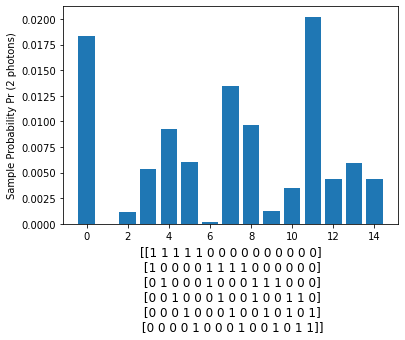

In [34]:
#plt.bar(xaxis,Pn)
plt.bar(range(npatterns),Pn)
plt.xlabel(np.transpose(np.array(ln)), fontsize=12);
plt.ylabel('Sample Probability Pr (2 photons)');

#plt.savefig('BS7pairsnotraining.eps', format='eps')


## Patterns with 4 photons

In [35]:
ln =patterns(4,nmodes)
print(len(ln))
npatterns=len(ln)
Pn = np.zeros([npatterns,], dtype=np.float32)
Pth = np.zeros_like(Pn)
xaxis=np.zeros_like(Pn)
for nbar in range(npatterns):
    print('Sample '+repr(nbar)+' of '+repr(npatterns)+' '+repr(ln[nbar]))
    Pn[nbar]=ps.Pr(ln[nbar],Qrho).numpy()
    tf.print(Pn[nbar])
    xaxis[nbar]=nbar
print('Done')


15
Sample 0 of 15 (1, 1, 1, 1, 0, 0)
0.00010046632
Sample 1 of 15 (1, 1, 1, 0, 1, 0)
0.0015550206
Sample 2 of 15 (1, 1, 1, 0, 0, 1)
0.0011629958
Sample 3 of 15 (1, 1, 0, 1, 1, 0)
0.00024092739
Sample 4 of 15 (1, 1, 0, 1, 0, 1)
0.0013681765
Sample 5 of 15 (1, 1, 0, 0, 1, 1)
0.0010672585
Sample 6 of 15 (1, 0, 1, 1, 1, 0)
2.107329e-05
Sample 7 of 15 (1, 0, 1, 1, 0, 1)
0.000452761
Sample 8 of 15 (1, 0, 1, 0, 1, 1)
0.00021571535
Sample 9 of 15 (1, 0, 0, 1, 1, 1)
0.0012343335
Sample 10 of 15 (0, 1, 1, 1, 1, 0)
0.000595476
Sample 11 of 15 (0, 1, 1, 1, 0, 1)
0.00041041692
Sample 12 of 15 (0, 1, 1, 0, 1, 1)
0.0053106896
Sample 13 of 15 (0, 1, 0, 1, 1, 1)
8.2093116e-05
Sample 14 of 15 (0, 0, 1, 1, 1, 1)
0.0007596619
Done


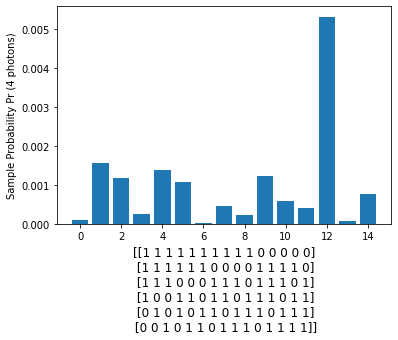

In [36]:
plt.bar(range(npatterns),Pn)
plt.xlabel(np.transpose(np.array(ln)), fontsize=12);
plt.ylabel('Sample Probability Pr (4 photons)');

## Compute the probability of pairs 

In [37]:
%%time
nmax = 2 # number of couples
probn=np.zeros([nmax+1,], dtype=np_real)
for j in range(nmax+1):
    photon_number=2*j
    # generate the patterns
    ln=patterns(photon_number,nmodes)
    npattern=len(ln)
    print('Generated '+repr(npattern)+\
          ' patterns with photon number '+repr(photon_number))
    # compute probability for each pattern
    Pn=np.zeros([npattern,], dtype=np_real)
    for nbar in range(npattern):        
        Pn[nbar]=ps.Pr(ln[nbar],Qrho).numpy()
        print('Photons '+repr(photon_number)+' Sample '+repr(nbar+1)+\
              ' of '+repr(npatterns)+' Pr=' +repr(Pn[nbar])+\
              ' pattern '+repr(ln[nbar]))
    # sum the probability of each pattern
    probn[j]=sum(Pn)
print('Done')

Generated 1 patterns with photon number 0
Photons 0 Sample 1 of 15 Pr=0.1257302314043045 pattern (0, 0, 0, 0, 0, 0)
Generated 15 patterns with photon number 2
Photons 2 Sample 1 of 15 Pr=0.01836654171347618 pattern (1, 1, 0, 0, 0, 0)
Photons 2 Sample 2 of 15 Pr=1.0598445442155935e-05 pattern (1, 0, 1, 0, 0, 0)
Photons 2 Sample 3 of 15 Pr=0.0011618905700743198 pattern (1, 0, 0, 1, 0, 0)
Photons 2 Sample 4 of 15 Pr=0.005373163148760796 pattern (1, 0, 0, 0, 1, 0)
Photons 2 Sample 5 of 15 Pr=0.009270756505429745 pattern (1, 0, 0, 0, 0, 1)
Photons 2 Sample 6 of 15 Pr=0.0060278126038610935 pattern (0, 1, 1, 0, 0, 0)
Photons 2 Sample 7 of 15 Pr=0.00014638155698776245 pattern (0, 1, 0, 1, 0, 0)
Photons 2 Sample 8 of 15 Pr=0.01343567669391632 pattern (0, 1, 0, 0, 1, 0)
Photons 2 Sample 9 of 15 Pr=0.009646307677030563 pattern (0, 1, 0, 0, 0, 1)
Photons 2 Sample 10 of 15 Pr=0.0012057079002261162 pattern (0, 0, 1, 1, 0, 0)
Photons 2 Sample 11 of 15 Pr=0.003456100821495056 pattern (0, 0, 1, 0, 1, 0

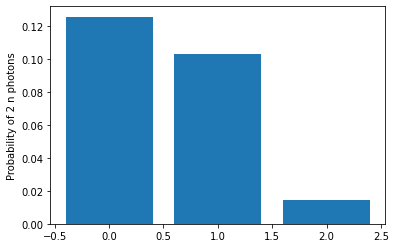

In [38]:
plt.bar(range(nmax+1),probn)
#plt.xlabel(ln, fontsize=6);
plt.ylabel('Probability of 2 n photons');

# Train the model and recompute probabilities

In [44]:
%%time
history=Train_model.fit(xtrain,np.zeros_like(xtrain),epochs=10000,verbose=0)

CPU times: user 1min 42s, sys: 4.16 s, total: 1min 46s
Wall time: 1min 20s


Plot training history

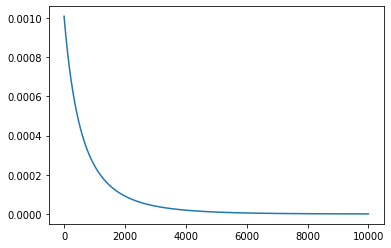

In [45]:
plt.plot(history.history['loss'])

## Recompute the transform after training

In [46]:
kin, Qrho =ps.getQTransformModel(model)

## Patterns with 2 photons

In [47]:
%%time
ln =patterns(2,nmodes)
print(len(ln))
npatterns=len(ln)
Pn = np.zeros([npatterns,], dtype=np.float32)
Pth = np.zeros_like(Pn)
xaxis=np.zeros_like(Pn)
for nbar in range(npatterns):
    print('Sample '+repr(nbar)+' of '+repr(npatterns)+' '+repr(ln[nbar]))
    Pn[nbar]=ps.Pr(ln[nbar],Qrho).numpy()
    tf.print(Pn[nbar])
    xaxis[nbar]=nbar
print('Done')

15
Sample 0 of 15 (1, 1, 0, 0, 0, 0)
0.004359359
Sample 1 of 15 (1, 0, 1, 0, 0, 0)
0.0
Sample 2 of 15 (1, 0, 0, 1, 0, 0)
0.0
Sample 3 of 15 (1, 0, 0, 0, 1, 0)
5.820766e-11
Sample 4 of 15 (1, 0, 0, 0, 0, 1)
-1.1641532e-10
Sample 5 of 15 (0, 1, 1, 0, 0, 0)
-2.3283064e-10
Sample 6 of 15 (0, 1, 0, 1, 0, 0)
-2.3283064e-10
Sample 7 of 15 (0, 1, 0, 0, 1, 0)
4.656613e-10
Sample 8 of 15 (0, 1, 0, 0, 0, 1)
4.656613e-10
Sample 9 of 15 (0, 0, 1, 1, 0, 0)
3.316556e-05
Sample 10 of 15 (0, 0, 1, 0, 1, 0)
4.1213585e-05
Sample 11 of 15 (0, 0, 1, 0, 0, 1)
9.1193244e-05
Sample 12 of 15 (0, 0, 0, 1, 1, 0)
0.0015321122
Sample 13 of 15 (0, 0, 0, 1, 0, 1)
0.0005979452
Sample 14 of 15 (0, 0, 0, 0, 1, 1)
0.0054417616
Done
CPU times: user 1.02 s, sys: 11.2 ms, total: 1.03 s
Wall time: 1.02 s


/home/claudio/anaconda3/envs/tfquomplex2/lib/python3.7/site-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


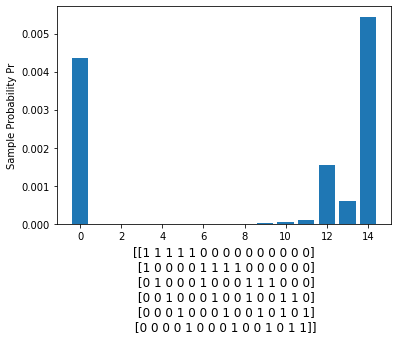

In [48]:
plt.bar(range(npatterns),Pn)
plt.xlabel(np.transpose(np.array(ln)), fontsize=12);
plt.ylabel('Sample Probability Pr');

## Patterns of 4 photons

In [50]:
%%time
ln =patterns(4,nmodes)
print(len(ln))
npatterns=len(ln)
Pn = np.zeros([npatterns,], dtype=np.float32)
Pth = np.zeros_like(Pn)
xaxis=np.zeros_like(Pn)
for nbar in range(npatterns):
    print('Sample '+repr(nbar)+' of '+repr(npatterns)+' '+repr(ln[nbar]))
    Pn[nbar]=ps.Pr(ln[nbar],Qrho).numpy()
    tf.print(Pn[nbar])
    xaxis[nbar]=nbar
print('Done')

15
Sample 0 of 15 (1, 1, 1, 1, 0, 0)
5.706912e-06
Sample 1 of 15 (1, 1, 1, 0, 1, 0)
7.090566e-06
Sample 2 of 15 (1, 1, 1, 0, 0, 1)
1.5683443e-05
Sample 3 of 15 (1, 1, 0, 1, 1, 0)
0.00026341478
Sample 4 of 15 (1, 1, 0, 1, 0, 1)
0.000102806596
Sample 5 of 15 (1, 1, 0, 0, 1, 1)
0.00093558594
Sample 6 of 15 (1, 0, 1, 1, 1, 0)
5.966285e-10
Sample 7 of 15 (1, 0, 1, 1, 0, 1)
6.220944e-10
Sample 8 of 15 (1, 0, 1, 0, 1, 1)
9.0221874e-10
Sample 9 of 15 (1, 0, 0, 1, 1, 1)
3.4815457e-09
Sample 10 of 15 (0, 1, 1, 1, 1, 0)
1.1641532e-10
Sample 11 of 15 (0, 1, 1, 1, 0, 1)
1.6007107e-10
Sample 12 of 15 (0, 1, 1, 0, 1, 1)
1.3242243e-09
Sample 13 of 15 (0, 1, 0, 1, 1, 1)
8.731149e-10
Sample 14 of 15 (0, 0, 1, 1, 1, 1)
1.573754e-05
Done
CPU times: user 34 s, sys: 0 ns, total: 34 s
Wall time: 33.9 s


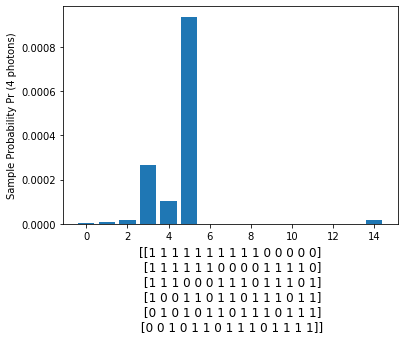

In [51]:
plt.xlabel(np.transpose(np.array(ln)), fontsize=12);
plt.bar(range(npatterns),Pn)
plt.ylabel('Sample Probability Pr (4 photons)');

# Check the weights of layers

In [52]:
model.layers

In [53]:
tf.print(model.layers[2].get_M())

([[-0.185043126 -0.38805306 -0.0738483667 ... 0.298891127 -0.168454856 -0.360883]
 [0.38805306 -0.185043126 0.0431848839 ... 0.156669185 0.360883 -0.168454856]
 [0.112321086 0.313956708 0.649087846 ... -0.151243821 -0.436094642 -0.131933689]
 ...
 [-0.101924464 0.578585088 -0.14001 ... 0.520286918 -0.132423043 0.0257488638]
 [0.0664659 -0.141118765 0.129513189 ... 0.341032952 0.229375601 0.0849813148]
 [0.141118765 0.0664659 -0.292629451 ... -0.392677188 -0.0849813148 0.229375601]], [[-0.185043126 0.38805306 0.112321086 ... -0.101924464 0.0664659 0.141118765]
 [-0.38805306 -0.185043126 0.313956708 ... 0.578585088 -0.141118765 0.0664659]
 [-0.0738483667 0.0431848839 0.649087846 ... -0.14001 0.129513189 -0.292629451]
 ...
 [0.298891127 0.156669185 -0.151243821 ... 0.520286918 0.341032952 -0.392677188]
 [-0.168454856 0.360883 -0.436094642 ... -0.132423043 0.229375601 -0.0849813148]
 [-0.360883 -0.168454856 -0.131933689 ... 0.0257488638 0.0849813148 0.229375601]])


# Compute the statistical probability of pairs

In [54]:
%%time
nmax = 2 # number of couples
probn=np.zeros([nmax+1,], dtype=np_real)
for j in range(nmax+1):
    photon_number=2*j
    # generate the patterns
    ln=patterns(photon_number,nmodes)
    npattern=len(ln)
    print('Generated '+repr(npattern)+\
          ' patterns with photon number '+repr(photon_number))
    # compute probability for each pattern
    Pn=np.zeros([npattern,], dtype=np_real)
    for nbar in range(npattern):        
        Pn[nbar]=ps.Pr(ln[nbar],Qrho).numpy()
        print('Photons '+repr(photon_number)+' Sample '+repr(nbar+1)+\
              ' of '+repr(npatterns)+' Pr=' +repr(Pn[nbar])+\
              ' pattern '+repr(ln[nbar]))
    # sum the probability of each pattern
    probn[j]=sum(Pn)
print('Done')

Generated 1 patterns with photon number 0
Photons 0 Sample 1 of 15 Pr=0.025355929508805275 pattern (0, 0, 0, 0, 0, 0)
Generated 15 patterns with photon number 2
Photons 2 Sample 1 of 15 Pr=0.004359358921647072 pattern (1, 1, 0, 0, 0, 0)
Photons 2 Sample 2 of 15 Pr=0.0 pattern (1, 0, 1, 0, 0, 0)
Photons 2 Sample 3 of 15 Pr=0.0 pattern (1, 0, 0, 1, 0, 0)
Photons 2 Sample 4 of 15 Pr=5.820766091346741e-11 pattern (1, 0, 0, 0, 1, 0)
Photons 2 Sample 5 of 15 Pr=-1.1641532182693481e-10 pattern (1, 0, 0, 0, 0, 1)
Photons 2 Sample 6 of 15 Pr=-2.3283064365386963e-10 pattern (0, 1, 1, 0, 0, 0)
Photons 2 Sample 7 of 15 Pr=-2.3283064365386963e-10 pattern (0, 1, 0, 1, 0, 0)
Photons 2 Sample 8 of 15 Pr=4.656612873077393e-10 pattern (0, 1, 0, 0, 1, 0)
Photons 2 Sample 9 of 15 Pr=4.656612873077393e-10 pattern (0, 1, 0, 0, 0, 1)
Photons 2 Sample 10 of 15 Pr=3.316556103527546e-05 pattern (0, 0, 1, 1, 0, 0)
Photons 2 Sample 11 of 15 Pr=4.121358506381512e-05 pattern (0, 0, 1, 0, 1, 0)
Photons 2 Sample 12 o

In [55]:
probn

array([0.0254, 0.0121, 0.0013])

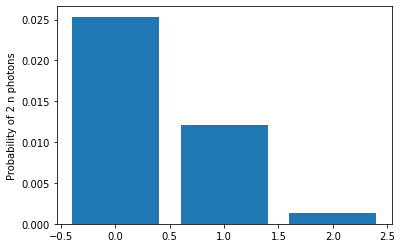

In [57]:
plt.bar(range(nmax+1),probn)
plt.ylabel('Probability of 2 n photons');

Looks that the overall probability does not change, but most of the couples appears in the target modes

In [58]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 12)]         0           []                               
                                                                                                  
 haar_layer_constant (HaarLayer  [(None, 12),        0           ['input_1[0][0]']                
 Constant)                       (12, 1)]                                                         
                                                                                                  
 random_layer (RandomLayer)     [(None, 12),         72          ['haar_layer_constant[0][0]',    
                                 (12, 1)]                         'haar_layer_constant[0][1]']    
                                                                                              

In [59]:
model.layers[3].r

<tf.Variable 'single_mode_squeezer_layer/r:0' shape=() dtype=float32, numpy=1.0019027>

In [60]:
model.layers[3].theta

<tf.Variable 'single_mode_squeezer_layer/theta:0' shape=() dtype=float32, numpy=0.7854839>

In [61]:
model.layers[4].r

<tf.Variable 'single_mode_squeezer_layer_1/r:0' shape=() dtype=float32, numpy=0.94487077>

In [62]:
model.layers[4].theta

<tf.Variable 'single_mode_squeezer_layer_1/theta:0' shape=() dtype=float32, numpy=0.78540343>

In [63]:
model.layers[5].r

<tf.Variable 'single_mode_squeezer_layer_2/r:0' shape=() dtype=float32, numpy=1.5628673>

In [64]:
model.layers[6].r

<tf.Variable 'single_mode_squeezer_layer_3/r:0' shape=() dtype=float32, numpy=1.8392518>

In [65]:
model.layers[7].r

<tf.Variable 'single_mode_squeezer_layer_4/r:0' shape=() dtype=float32, numpy=0.9276404>

In [66]:
model.layers[8].r

<tf.Variable 'single_mode_squeezer_layer_5/r:0' shape=() dtype=float32, numpy=0.93269795>